# Parallel DBSCAN implementation
Based on Huang, Fang, Qiang Zhu, Ji Zhou, Jian Tao, Xiaocheng Zhou, Du Jin, Xicheng Tan, and Lizhe Wang. "Research on the parallelization of the DBSCAN clustering algorithm for spatial data mining based on the spark platform." Remote Sensing 9, no. 12 (2017): 1301.

## Implementation ditails
1. Performance optimizations suggested by the authors of the paper:
    1. Spark broadcast variables and accumulators in order to improve performance
    1. KyroSerizalizer for data serialization


## Difference from the 

## Definitions
* __Core points:__ a point _p_ is a _core_ point if it has neighbors within a given radius _(eps)_ and the number of neighbors is at least _minpts_.
* __Directly density-reachable:__ a point _y_ is directly _density-reachable_ from _x_ if _y_ is within _eps-neighborhood_ of _x_ and _x_ is a _core point_.
* __Density-reachable:__ a point _y_ is _density-reachable_ from x if there is a chain of points _p1, p2, ..., pn=y_ such that p1 is directly density-reachable and _p2, ..., pn_ are directly density-reachable to each previous point in the chain.

## Algorithm outline
1. Split the data to partitions
1. Apply the traditional DBSCAN on each box and assign each point to a cluster within the boxes
1. Merge clusters: If the same point has been lableled as part of a cluster in two different boxes, it means that those two clusters are actually one single cluster and they should be merged

In [1]:
import math

from numpy import array
import numpy as np

from sklearn.cluster import DBSCAN

import matplotlib
import matplotlib.pyplot as plt

import pyspark
from pyspark import SparkConf, SparkContext

import operator

In [2]:
# Enable inline plots
%matplotlib inline


conf = sc.getConf()
conf.set("spark.python.profile", "true") # For debug
conf.set("spark.driver.memory", "16G")   # TODO: Should be adapted to the environment
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer") # Recommended by the authors
sc.setLogLevel('ERROR')

# For reproducability of results
RANDOM_SEED = 30
sc.getConf().getAll()

[('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1637440809181'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.app.id', 'local-1637440809781'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '33909'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '192.168.48.128'),
 ('spark.sql.warehouse.dir',
  'file:/home/anton/sparkworkspace/notebooks/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true')]

In [3]:
def parse_line(line):
    data_vector = tuple(map(float, line.strip().split()[:2]))
    key = hash(line)
    return key, data_vector

data = sc.textFile("../data_samples/dbscan.txt")
parsed_data = data.map(lambda line: parse_line(line))
parsed_data.cache()
parsed_data.take(5)

[(3195514837474607533, (15.55, 28.65)),
 (2828153323134883938, (14.9, 27.55)),
 (4565759698401697272, (14.45, 28.35)),
 (-7821634222920811163, (14.15, 28.8)),
 (3976224833405897861, (13.75, 28.05))]

In [4]:
clustering = DBSCAN(eps=1.2, min_samples=3).fit(parsed_data.map(operator.itemgetter(1)).collect())
labels = clustering.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [5]:
def cmap_with_noice(ncolros=7):
    """
    Create a special color map for DBSCAN alorithm.
    It uses a regualr color map but map the smallest value to black.
    We asume that the noice is labled with -1 and all the other labels are non negative
    """
    rainbow = plt.get_cmap('rainbow', ncolros)
    newcolors = rainbow(np.linspace(0, 1, ncolros))
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors, 0, black, 0)  
    return matplotlib.colors.ListedColormap(newcolors)

dbscan_cmap = cmap_with_noice()

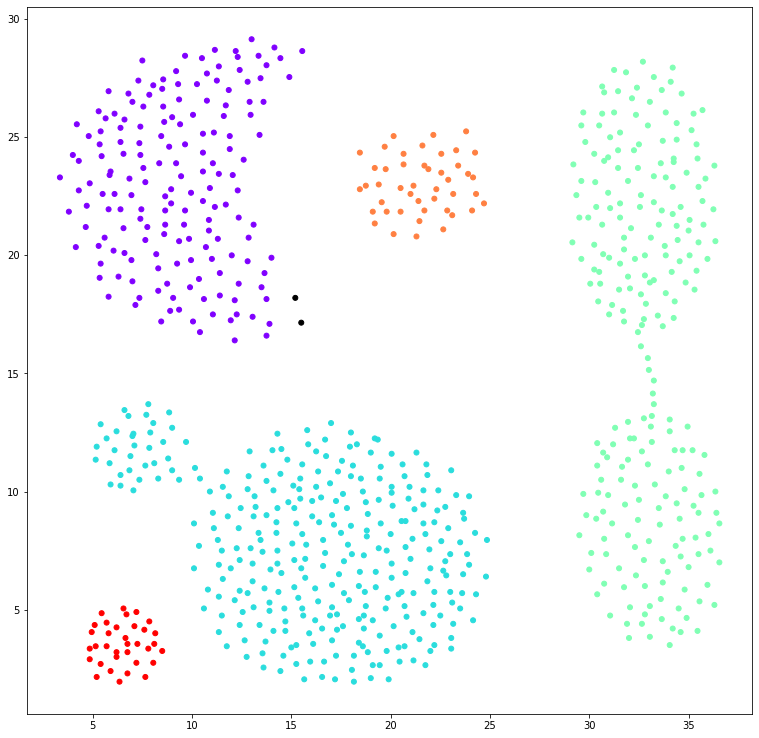

In [6]:
x, y = zip(*parsed_data.map(operator.itemgetter(1)).collect())

fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=25, c=labels, cmap=dbscan_cmap, marker="o")

In [7]:
parsed_data.map(operator.itemgetter(1)).toDF().describe().show()

+-------+-----------------+------------------+
|summary|               _1|                _2|
+-------+-----------------+------------------+
|  count|              788|               788|
|   mean|19.56681472081219|14.171763959390871|
| stddev|9.922042363186147| 8.089683474291608|
|    min|             3.35|              1.95|
|    max|            36.55|             29.15|
+-------+-----------------+------------------+



In [33]:
def get_grid(data: pyspark.RDD, partitions_per_axis=4):
    """
    :param data: RDD of sturcutre (key, k-dim vector)
    :param partitions_per_axis: number of partitions to generate on each of the axis.
        final partitions number will be partitions_per_axis ** k
    :returns: 2D array, each row contains represents a linspace vector for coresponding axis
    """
    df = parsed_data.map(operator.itemgetter(1)).toDF()
    min_values = array(df.describe().filter('summary = "min"').rdd.collect()[0][1:], float)
    max_values = array(df.describe().filter('summary = "max"').rdd.collect()[0][1:], float)
    return np.linspace(
        start=min_values, 
        stop=max_values, 
        num=partitions_per_axis, 
        endpoint=False,
        axis=1
    )

In [34]:
def set_partition_labels(data: pyspark.RDD, grid: np.array):
    """
    :param data: each row of form ((key, k-dim vector)
    :param grid: 2D array represntation of the grid. 
        Each row is a linspace vector reprentig intervals for specific axis
    :returns: new pyspark.RDD with the same strucutre as structured_data were 
        each partition is set to be the position of ((key, partition, claster), k-dim vector)
    """
    def get_partition(point):
        return tuple(np.searchsorted(axis, coordinate, side='right') for axis, coordinate in zip(grid, point))
        
    return data.map(
        lambda row: (get_partition(row[1]), ((row[0], 0), row[1]))
    )

In [ ]:
def expand_boundary(partition_labeled_data: pysarpk:RDD):
    
    

In [35]:
def PDBSCAN(data: pyspark.RDD, eps: float, min_points: int):
    """
    :param data: RDD of structure (key, k-dim vector)
    """
    grid = get_grid(data)
    print(grid)
    partition_labeled_data = set_partition_labels(data, grid)
    return expand_boundary(partition_labeled_data)
    
result = PDBSCAN(parsed_data, 3, 3)

[[ 3.35 11.65 19.95 28.25]
 [ 1.95  8.75 15.55 22.35]]


In [36]:
result.take(10)

[((2, 4), ((3195514837474607533, 0), (15.55, 28.65))),
 ((2, 4), ((2828153323134883938, 0), (14.9, 27.55))),
 ((2, 4), ((4565759698401697272, 0), (14.45, 28.35))),
 ((2, 4), ((-7821634222920811163, 0), (14.15, 28.8))),
 ((2, 4), ((3976224833405897861, 0), (13.75, 28.05))),
 ((2, 4), ((-8228871441322775038, 0), (13.35, 28.45))),
 ((2, 4), ((-3885287772402800124, 0), (13.0, 29.15))),
 ((2, 4), ((6452512849696334994, 0), (13.45, 27.5))),
 ((2, 4), ((-5308528290577641607, 0), (13.6, 26.5))),
 ((2, 4), ((7449355781833966640, 0), (12.8, 27.35)))]

In [37]:
distinct_partitions = result.keys().distinct()
distinct_partitions.collect()

[(2, 4),
 (1, 3),
 (2, 2),
 (1, 1),
 (3, 1),
 (4, 2),
 (4, 4),
 (3, 3),
 (1, 4),
 (2, 3),
 (1, 2),
 (2, 1),
 (3, 2),
 (4, 1),
 (4, 3),
 (3, 4)]

In [38]:
len(distinct_partitions.collect())

16